In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

In [9]:
#lasso 部分 对应那个视频
#先从表格读取数据
data=pd.read_csv('./new_data.csv')

test_data=data.sample(frac=0.1,axis=0) #从原来的表里面随机取出10%的数据做测试集,按行
train_data=data[~data.index.isin(test_data.index)] #剔除test_data的样本，作为训练集

x_train=train_data[train_data.columns[1:]]
y_train=train_data['label']
colNames=x_train.columns

x_test=test_data[test_data.columns[1:]]
y_test=test_data['label']

   label  Elongation  Flatness  LeastAxisLength  MajorAxisLength  \
8      1     0.64626  0.512811         38.20333         74.49793   

   Maximum2DDiameterColumn  Maximum2DDiameterRow  Maximum2DDiameterSlice  \
8                61.269895             79.699435               71.449283   

   Maximum3DDiameter   MeshVolume  ...  SmallAreaHighGrayLevelEmphasis.8  \
8          80.131143  92539.54167  ...                         32.001671   

   SmallAreaLowGrayLevelEmphasis.8  ZoneEntropy.8  ZonePercentage.8  \
8                         0.005164       6.766311          0.009169   

   ZoneVariance.8  Busyness.8  Coarseness.8  Complexity.8  Contrast.17  \
8     2310535.242   36.417059      0.000115     47.658339     0.006993   

   Strength.8  
8    0.019358  

[1 rows x 852 columns]
---------------------------------------------
   label  Elongation  Flatness  LeastAxisLength  MajorAxisLength  \
0      1    0.836619  0.576249        17.467560        30.312511   
1      1    0.716841  0.460

In [2]:


#规整化x
x=x.astype(np.float64)
x=StandardScaler().fit_transform(x)
x=pd.DataFrame(x)
x.columns=colNames
x_raw=x
#调用sklearn的lasso方法，对x，y建模
'''
这里有几个参数，具体用法需要知道lasso算法的具体步骤
我们先用视频中的参数试一下，之后您进行调参，需要具体了解lasso
因为我们的样本不够多，这里我做了稍微调整

'''
model=LassoCV(alphas=np.logspace(-3,1,200),cv=2,max_iter=10000).fit(x,y)

#建模之后，我们可以在model里取得我们需要的信息
print(model.alpha_)
coef=pd.Series(model.coef_,index=x.columns)
print("Lasso picked \n"
      +str(sum(coef!=0))
      +"\n variables and eliminated the other \n"
      +str(sum(coef==0)))

#输出降维后的特征
index = coef[coef !=0].index
x=x[index]
print(coef[coef !=0])

10.0
Lasso picked 
0
 variables and eliminated the other 
851
Series([], dtype: float64)


In [3]:
def draw2(model,a1,a2,a3,max_iter=10000):
    """
    输入:model,lasso模型,a1,a2,a3,分别为logspace三个参数
    """
    coefs=model.path(x_raw,y,alphas=np.logspace(a1,a2,a3),max_iter=max_iter)[1].T
    fig,ax_f=plt.subplots()
    plt.xlim(10**a1,10**a2)
    ax_c=ax_f.twiny()
    ax_f.semilogx(model.alphas_,coefs,'-')
    ax_f.axvline(model.alpha_,color='black',ls='--')
    ax_f.set_xlabel('Lambda')
    ax_f.set_ylabel('Coefficients')
    
    ncoefs=coefs.copy()
    ncoefs[ncoefs!=0]=1
    xsum=ncoefs.sum(axis=1)

    #print(list(range(a3))[::40],xsum[::40])
    k=a3//(a2-a1+1)
    ax_c.set_xticks(list(range(a3))[::k],labels=list(map(int,xsum))[::k])
    ax_c.invert_xaxis()
    plt.show()

    MSEs=(model.mse_path_)
    MSEs_mean=np.apply_along_axis(np.mean,1,MSEs)
    MSEs_std=np.apply_along_axis(np.std,1,MSEs)

    fig,ax_f=plt.subplots()
    plt.xlim(10**a1,10**a2)
    ax_c=ax_f.twiny()
    k=a3//20
    ax_c.set_xticks(list(range(a3))[::10],labels=list(map(int,xsum))[::10])
    ax_c.invert_xaxis()
    ax_f.errorbar(model.alphas_,MSEs_mean
                 ,yerr=MSEs_std
                 ,fmt="o"
                 ,ms=1
                 ,mfc="r"
                 ,mec="r"
                 ,ecolor="lightblue"
                 ,elinewidth=1
                 ,capsize=3
                 ,capthick=1)
    ax_f.semilogx()

    ax_f.axvline(model.alpha_,color='black',ls='--')
    ax_f.set_xlabel('Lambda')
    ax_f.set_ylabel('*Binomial Deviance')
    ax=plt.gca()
    y_major_locator=MultipleLocator(0.06)
    ax.yaxis.set_major_locator(y_major_locator)
    plt.show()

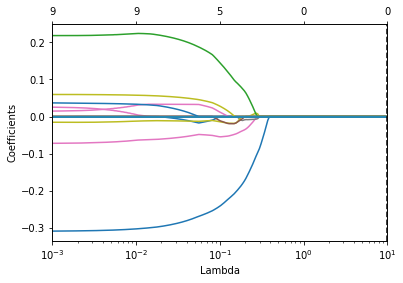

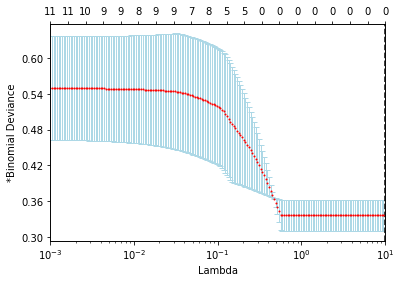

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
draw2(model,-3,1,200,max_iter=10000)